# 선형회귀 예시 (2) - 의료비에 영향을 미치는 요소

## #01. 작업 준비

### 1. 패키지 참조하기

In [27]:
import sys
sys.path.append("../../")
import helper

import numpy as np
from pandas import read_excel, DataFrame, merge, get_dummies
from pca import pca
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from matplotlib import pyplot as plt
import seaborn as sb
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

### 2. 데이터 가져오기

미국 환자의 의료비가 들어 있는 데이터셋으로 `1,338`개의 관측치가 있다.

| 변수 | 의미 | 기타 |
|---|---|---|
| age | 수익자의 연령 | 수치형 |
| sex | 계약자의 성별 | 범주형 데이터(female/male) |
| bmi | 미만도. 몸무게를 키의 제곱으로 나눈 값. | 수치형<br/>정상범위: 18.5~24.9 |
| children | 의료보험이 적용되는 자녀 수 | 수치형 데이터 |
| smoker | 흡연 여부 | 범주형 데이터(yes/no) |
| region | 거주지역 | 범주형<br/>(북동: northeast, 남동: southeast / 남서: southwest / 북서: northwest) |
| expense | 의료비 | 수치형 데이터 |

In [28]:
origin = read_excel("https://data.hossam.kr/E04/insurance.xlsx")
origin

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## #02. 데이터 전처리

### 1. 데이터 프레임 복사 후 결측치와 데이터 타입 확인

In [29]:
edf = origin.copy()
helper.prettyPrint(edf.isna().sum(), title="결측치 개수")
helper.prettyPrint(edf.dtypes, title="데이터 타입")

+----------+---------------+
|          |   결측치 개수 |
|----------+---------------|
| age      |             0 |
| sex      |             0 |
| bmi      |             0 |
| children |             0 |
| smoker   |             0 |
| region   |             0 |
| charges  |             0 |
+----------+---------------+
+----------+---------------+
|          | 데이터 타입   |
|----------+---------------|
| age      | int64         |
| sex      | object        |
| bmi      | float64       |
| children | int64         |
| smoker   | object        |
| region   | object        |
| charges  | float64       |
+----------+---------------+


### 2. 범주형 타입 변환

#### 범주형 필드 이름

In [30]:
cnames = ["sex", "smoker", "region"]
cnames

['sex', 'smoker', 'region']

#### 범주형 컬럼 타입 변환

In [31]:
edf2 = helper.setCategory(edf, fields=cnames, labelling=False)
helper.prettyPrint(edf2.dtypes, title="데이터 타입")

+----------+---------------+
|          | 데이터 타입   |
|----------+---------------|
| age      | int64         |
| sex      | category      |
| bmi      | float64       |
| children | int64         |
| smoker   | category      |
| region   | category      |
| charges  | float64       |
+----------+---------------+


## #03. 탐색적 데이터 분석

### 1. 수치형 변수

#### 1) 기초 통계량 확인

수치형 데이터 타입은 전체적인 통계값을 파악하는 것이 좋다.

In [32]:
desc = edf2.describe()
helper.prettyPrint(desc)

+-------+--------+---------+------------+-----------+
|       |    age |     bmi |   children |   charges |
|-------+--------+---------+------------+-----------|
| count |   1338 |    1338 |       1338 |      1338 |
| mean  | 39.207 | 30.6634 |    1.09492 |   13270.4 |
| std   |  14.05 | 6.09819 |    1.20549 |     12110 |
| min   |     18 |   15.96 |          0 |   1121.87 |
| 25%   |     27 | 26.2963 |          0 |   4740.29 |
| 50%   |     39 |    30.4 |          1 |   9382.03 |
| 75%   |     51 | 34.6938 |          2 |   16639.9 |
| max   |     64 |   53.13 |          5 |   63770.4 |
+-------+--------+---------+------------+-----------+


> 의료비지출 변수의 통계값을 살펴보면 중앙값이 `$9,382`이고, 평균이 `$13,270`인 것을 알 수 있다. 여기서 해당 변수의 평균값이 중앙값보다 크기 때문에 의료비 분포는 오른쪽으로 꼬리가 긴 분포를 지닐 것이다. 

### 2) 전체 상자그림 확인

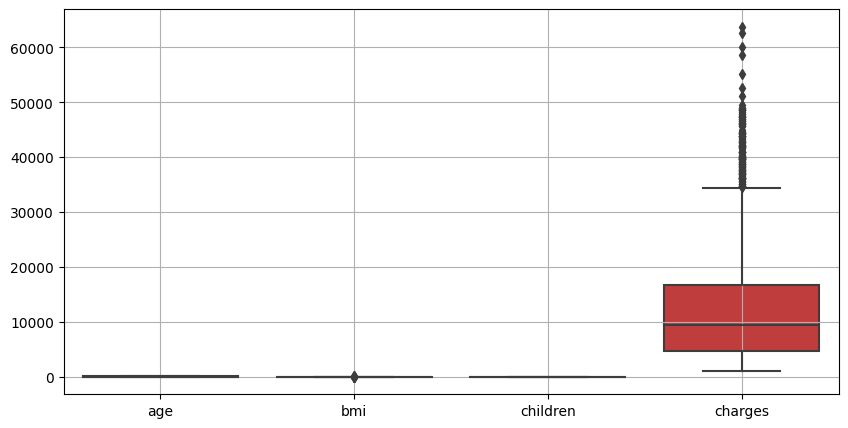

In [33]:
plt.figure(figsize=(10, 5))
sb.boxplot(data=edf)
plt.grid()
plt.show()
plt.close()

### 3) 개별 상자그림 확인

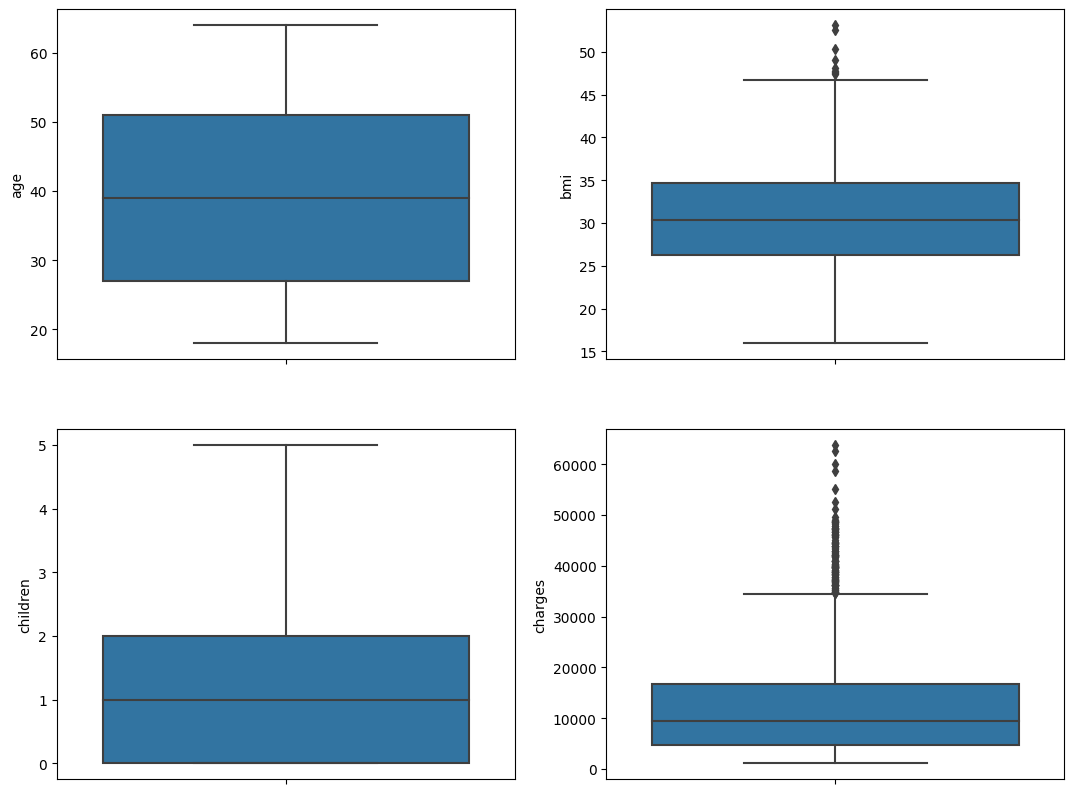

In [34]:
fig, ax = plt.subplots(2,2, figsize=(13, 10))
rows = len(ax)
cols = len(ax[0])

for i in range(0, rows):
    for j in range(0, cols):
        idx = i * cols + j
        fieldName = desc.columns[idx]
        field = edf2[fieldName]
        sb.boxplot(edf, y=field, ax=ax[i][j])
        
        if idx+1 == len(desc.columns):
            break

plt.show()
plt.close()

#### 4) 히스토그램 확인

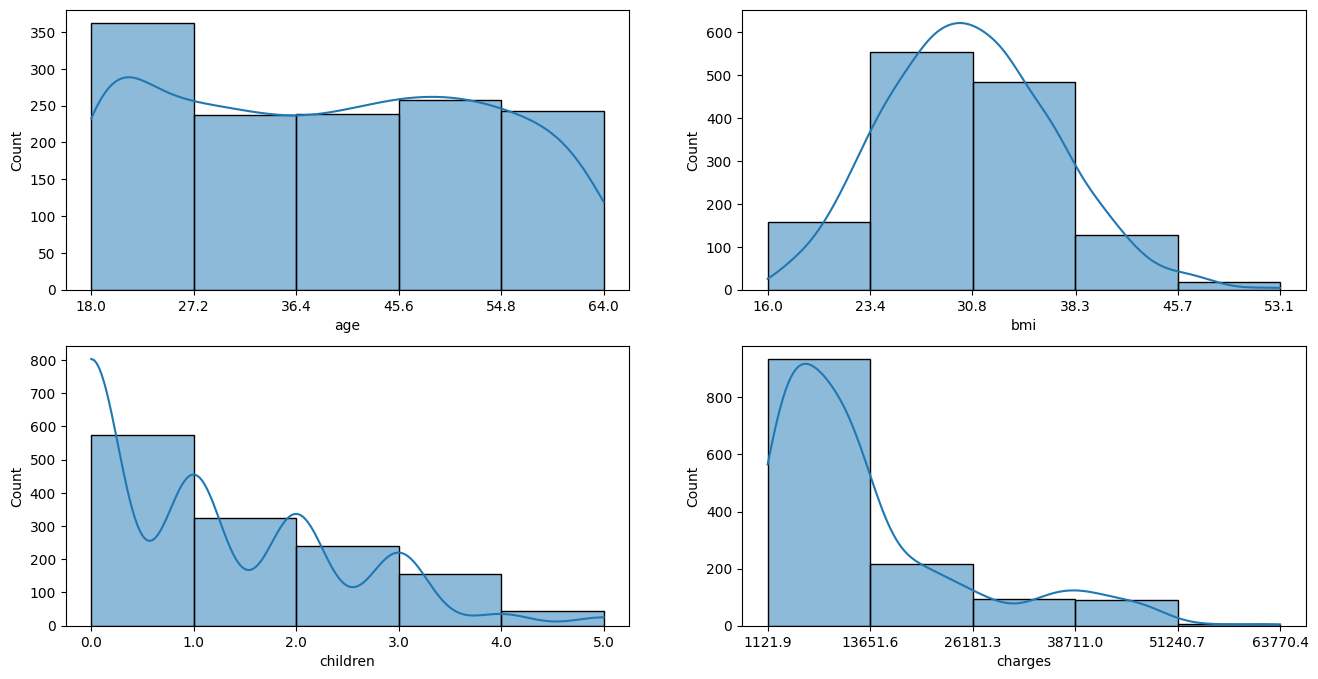

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

rows = len(ax)
cols = len(ax[0])

for i in range(rows):
    for j in range(cols):
        idx = i * cols + j
        fieldName = desc.columns[idx]
        field = edf[fieldName]
        
        hist, bins = np.histogram(field, bins=5)
        bins2 = np.round(bins, 1)
        
        sb.histplot(data=edf2, x=fieldName, bins=5, kde=True, ax=ax[i][j])
        ax[i][j].set_xticks(bins2)
        ax[i][j].set_xticklabels(bins2)
        
        if idx+1 == len(desc.columns):
            break
plt.show()
plt.close()

> 대부분의 사람들은 연간 $15,000 이하의 의료비 지출에 분포되어 있음을 알 수 있다.
>
> 마찬가지로 bmi지수를 살펴보면 과체중이상의 데이터가 절반 이상을 차지하는 것을 알 수 있다.

### 4) 각 변수간의 관계 파악

#### 수치형 변수들의 이름

In [36]:
nnames = list(desc.columns)
nnames

['age', 'bmi', 'children', 'charges']

In [37]:
ndf = edf.filter(nnames)
ndf.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


#### 산점도 행렬

> 실행 속도 관계로 주석으로 막아둠

In [38]:
# plt.figure(figsize=(20, 20))
# g = sb.pairplot(ndf, diag_kind='kde')
# g.map_upper(sb.kdeplot, alpha=0.3)
# g.map_lower(sb.regplot, scatter=False, truncate=False, ci=False)
# plt.savefig("pairplot.png", dpi=200)
# plt.show()
# plt.close()

![pairplot.png](pairplot.png)

> 이 그림에서 어떤 패턴이 눈에 띄는지 살펴보면 특정한 관계를 찾기는 어려워보임
>
> 여기 연령과 의료비지출의 산포도를 살펴보니, 상대적으로 직선 형태로 분포되어 있음을 볼 수 있다.
>
> 또, bmi지수와 의료비지출은 크게 두 개의 군집(cluster)로 나뉘어져 있는 것으로 보인다. 
>
> 전체적으로 강한 상관관계를 보이지는 않지만 `age-bmi`, `age-charges`, `children-charges`가 약한의 상관관계를 보인다.
>
> 나이가 들수록 몸무게가 증가하고, bmi 수치가 높거나 부양가족 수가 많아질 수록 의료비가 증가하는 것은 어느정도 합리적인 결과라 할 수 있겠다.

#### 상관행렬

대각선은 변수 자신이기 때문에 항상 '1'이 표기됨.

상관계수는 1에 가까울 수록 두 변수가 같은 방향으로 양의 상관관계가 높다고 판단할 수 있고, -1에 가까울 수록 반대 방향으로 음의 상관관계가 높다는 것을 나타냄

In [39]:
corr = ndf.corr(method='pearson')
helper.prettyPrint(corr)

+----------+----------+-----------+------------+-----------+
|          |      age |       bmi |   children |   charges |
|----------+----------+-----------+------------+-----------|
| age      |        1 |  0.109272 |   0.042469 |  0.299008 |
| bmi      | 0.109272 |         1 |  0.0127589 |  0.198341 |
| children | 0.042469 | 0.0127589 |          1 | 0.0679982 |
| charges  | 0.299008 |  0.198341 |  0.0679982 |         1 |
+----------+----------+-----------+------------+-----------+


>  연령, bmi지수, 부양가족 수, 의료비지출은 약하지만 모두 양(+)의 상관관계를 보이고 있다.
>
> 예를 들어, 연령과 bmi지수는 나이가 들어갈 수록 몸무게가 증가되면서 bmi 지수가 높아지는 경향을 설명할 수 있고, 부양가족 수가 증가하면 의료비 지출이 많아진다고 보는 것도 합리적인 판단이 될 수 있다. 

### 5) PCA 분석

회귀분석에 필요한 요인들을 선정하기 위해 주성분 분석을 수행한다.

#### 데이터 표준화

범주형은 PCA를 수행할 수 없기 때문에 수치형 변수만 추출해 둔 `ndf`를 사용한다.

종속 변수인 의료비 필드는 제외하고 진행한다.

In [40]:
x_train_std_df, y_train_std_df = helper.scalling(ndf[nnames], 'charges')
x_train_std_df

,age,bmi,children
0,-1.438764,-0.453320,-0.908614
1,-1.509965,0.509621,-0.078767
2,-0.797954,0.383307,1.580926
3,-0.441948,-1.305531,-0.908614
4,-0.513149,-0.292556,-0.908614
...,...,...,...
1333,0.768473,0.050297,1.580926
1334,-1.509965,0.206139,-0.908614
1335,-1.509965,1.014878,-0.908614
1336,-1.296362,-0.797813,-0.908614


#### PCA

In [41]:
model = pca()
# 표준화 결과를 활용하여 주성분 분석 수행
fit = model.fit_transform(x_train_std_df)
topfeat = fit['topfeat']

best = topfeat.query("type=='best'")
best_names = list(set(list(best['feature'])))
print(best_names)

topfeat

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [3] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [3] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [3] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
['age', 'children']


,PC,feature,loading,type
0,PC1,age,0.692028,best
1,PC2,children,0.931148,best
2,PC3,age,-0.717326,best
3,PC3,bmi,0.669385,weak


### 2. 범주형 변수

#### 1) 종류별로 데이터 수량 확인

In [42]:
for name in cnames:
    helper.prettyPrint(edf2[name].value_counts(), title="count")

+--------+---------+
| sex    |   count |
|--------+---------|
| male   |     676 |
| female |     662 |
+--------+---------+
+----------+---------+
| smoker   |   count |
|----------+---------|
| no       |    1064 |
| yes      |     274 |
+----------+---------+
+-----------+---------+
| region    |   count |
|-----------+---------|
| southeast |     364 |
| northwest |     325 |
| southwest |     325 |
| northeast |     324 |
+-----------+---------+


### 2) 범주형 데이터의 데이터 분포 시각화

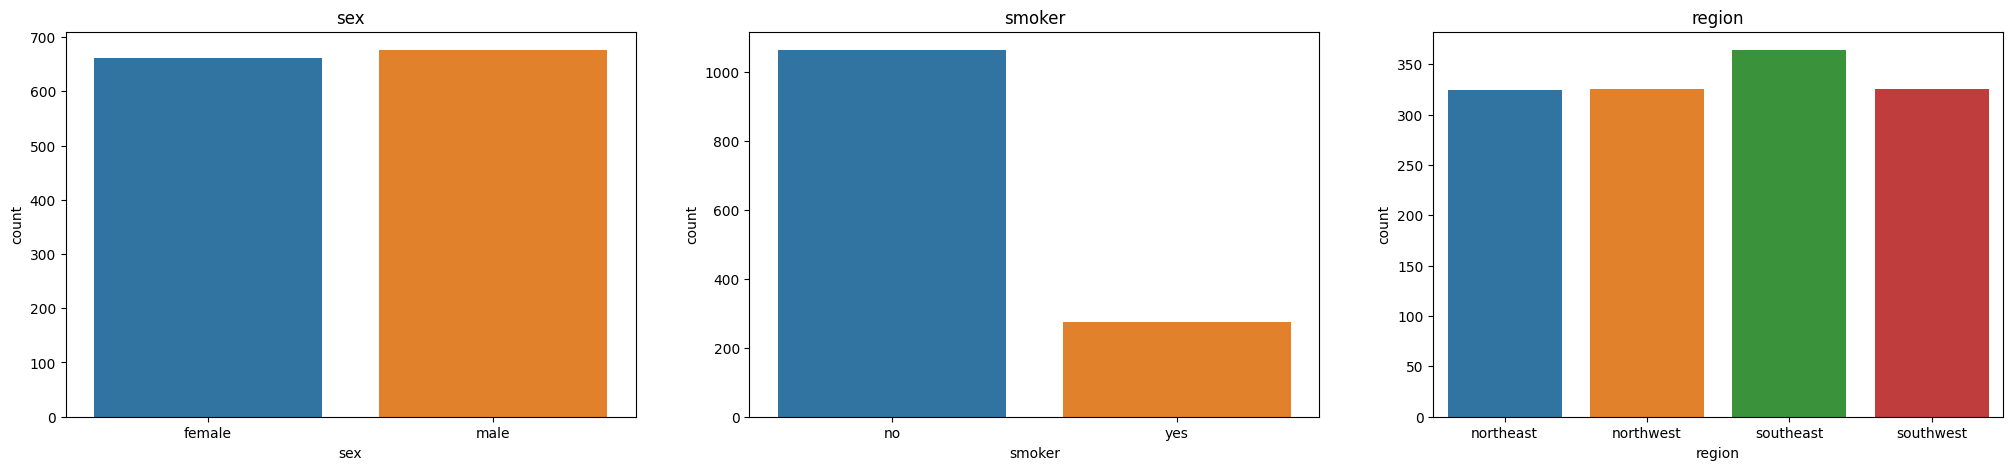

In [43]:
fig, ax = plt.subplots(1, len(cnames), figsize=(25, 5))

for i, v in enumerate(cnames):
    vc = DataFrame(edf2[v].value_counts(), columns=['count'])
    #print(vc)
    sb.barplot(data=vc, x=vc.index, y='count', ax=ax[i])
    ax[i].set_title(v)
    
plt.show()
plt.close()

> 흡연 여부의 경우 비흡연자가 많이 분포되어 있다.
>
> 그 밖에 성별과 지역의 경우 비슷하게 분포되어 있기 때문에 분산분석을 통해 통제요인으로 넣는 것을 고려해 볼 수 있겠다.

### 3) 범주형 변수에 따라 평균이 차이가 나는지 확인하기

#### 라벨링을 적용한 데이터프레임 생성

In [44]:
ldf = helper.setCategory(edf, fields=cnames, labelling=True)
helper.prettyPrint(ldf.dtypes)

{'female': 0, 'male': 1}
{'no': 0, 'yes': 1}
{'northeast': 0, 'northwest': 1, 'southeast': 2, 'southwest': 3}
+----------+---------+
|          | value   |
|----------+---------|
| age      | int64   |
| sex      | int32   |
| bmi      | float64 |
| children | int64   |
| smoker   | int32   |
| region   | int32   |
| charges  | float64 |
+----------+---------+


#### 분산분석

In [45]:
lm = ols('charges ~ C(sex)+C(smoker)+C(region)+C(sex):C(smoker)+C(smoker):C(region)+C(region):C(sex)+C(sex):C(smoker):C(region)', data=ldf).fit()
lmdf = anova_lm(lm)
lmdf['결과'] = lmdf['PR(>F)'] < 0.05
helper.prettyPrint(lmdf)

+----------------------------+------+-------------+-------------+------------+--------------+--------+
|                            |   df |      sum_sq |     mean_sq |          F |       PR(>F) | 결과   |
|----------------------------+------+-------------+-------------+------------+--------------+--------|
| C(sex)                     |    1 |  6.4359e+08 |  6.4359e+08 |      11.73 |  0.000633837 | True   |
| C(smoker)                  |    1 | 1.20878e+11 | 1.20878e+11 |    2203.11 | 7.87212e-284 | True   |
| C(region)                  |    3 |   1.078e+08 | 3.59335e+07 |    0.65492 |     0.579903 | False  |
| C(sex):C(smoker)           |    1 | 4.90416e+08 | 4.90416e+08 |    8.93829 |   0.00284416 | True   |
| C(smoker):C(region)        |    3 | 1.34408e+09 | 4.48028e+08 |    8.16573 |  2.18111e-05 | True   |
| C(region):C(sex)           |    3 | 1.38228e+06 |      460760 | 0.00839778 |     0.998944 | False  |
| C(sex):C(smoker):C(region) |    3 | 7.51706e+07 | 2.50569e+07 |   0.45668

> 성별과 흡연 여부에 대한 p값이 모두 0.05 미만이므로 두 요인은 의료비 지출에 통계적으로 유의미한 영향을 미친다고 볼 수 있다.
>
> 성별과 흡연량, 흡연량과 지역 간에는 교효작용 효과가 있음이 발견되었다.

#### 교효작용을 보이는 변수간의 비교

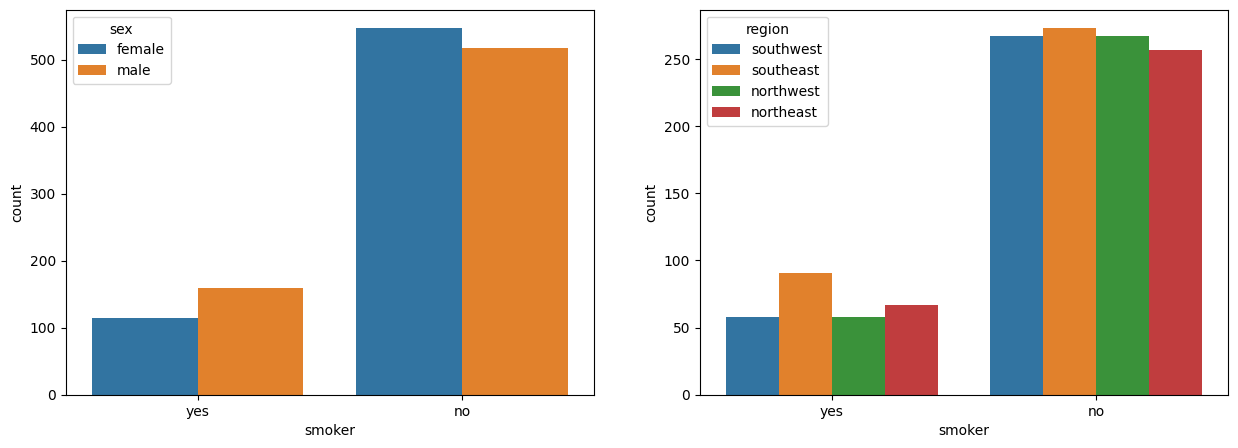

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sb.countplot(data=edf, x='smoker', hue='sex', ax=ax1)    
sb.countplot(data=edf, x='smoker', hue='region', ax=ax2)

plt.show()
plt.close()

## #04. 최종적으로 선정된 요인

| 구분 | 변수 | 의미 | 기타 |
|---|---|---|---|
| 종속변수 | charges | 의료비 | 수치형 데이터 |
| 독립변수 | age | 수익자의 연령 | 수치형 |
| 독립변수 | bmi(?) | 미만도. 몸무게를 키의 제곱으로 나눈 값. | 수치형<br/>정상범위: 18.5~24.9 |
| 독립변수 | children | 의료보험이 적용되는 자녀 수 | 수치형 데이터 |
| 통제요인 | sex | 계약자의 성별 | 범주형 데이터(female/male) |
| 통제요인 | smoker | 흡연 여부 | 범주형 데이터(yes/no) |

## #05. 다중선형회귀 분석

- case 1 : 모든 변수 적용
- case 2 : bmi를 제거하고 적용
- case 3 : 모든 변수 적용 + 표준화 적용
- case 4 : bmi를 제거하고 적용 + 표준화 적용

### 1. 분석 케이스에 따른 분석용 데이터 생성

In [47]:
def get_df(case_number, is_scale=False):
    # bmi를 제거하지 않은 경우
    if case_number == 1:
        # 사용할 변수 이름들
        fnames1 = ['charges', 'age', 'bmi', 'children', 'sex', 'smoker']
        # fname1 중에서 더미변수로 처리할 변수 이름들
        fnames2 = ['sex', 'smoker']
    # bmi를 제거한 경우
    elif case_number == 2:
        # 사용할 변수 이름들
        fnames1 = ['charges', 'age', 'children', 'sex', 'smoker']
        # fname1 중에서 더미변수로 처리할 변수 이름들
        fnames2 = ['sex', 'smoker']
    # 성별을 제거한 경우
    elif case_number == 3:
        # 사용할 변수 이름들
        fnames1 = ['charges', 'age', 'bmi', 'children', 'smoker']
        # fname1 중에서 더미변수로 처리할 변수 이름들
        fnames2 = ['smoker']
    # 성별과 bmi을 제거한 경우
    elif case_number == 4:
        # 사용할 변수 이름들
        fnames1 = ['charges', 'age', 'children', 'smoker']
        # fname1 중에서 더미변수로 처리할 변수 이름들
        fnames2 = ['smoker']
        
    # 표준화를 적용하지 않은 경우
    if not is_scale:
        tmp = origin.filter(fnames1)
    # 표준화를 적용한 경우
    else:
        # 미리 적용해 둔 표준화 결과를 병합
        left = merge(x_train_std_df, y_train_std_df, left_index=True, right_index=True).filter(fnames1)
        # 원본에서 명목형만 다시 추출
        right = origin.filter(fnames2)
        # 결합
        tmp = merge(left, right, left_index=True, right_index=True)
        None
        
    tmp2 = get_dummies(tmp, columns=fnames2, drop_first=True, dtype='int')
    return tmp2

In [48]:
target_df = get_df(3, True)
helper.prettyPrint(target_df.head())

# 독립변수 이름만 추출
xnames = list(target_df.columns)
xnames.remove('charges')
#xnames

ols_result = helper.myOls(target_df, y='charges', x=xnames)

helper.prettyPrint(ols_result.table)
print(ols_result.result, end="\n\n")

print(ols_result.goodness, end="\n\n")

for i in ols_result.varstr:
    print(i)

+----+-----------+-----------+-----------+------------+--------------+
|    |   charges |       age |       bmi |   children |   smoker_yes |
|----+-----------+-----------+-----------+------------+--------------|
|  0 |  0.298584 |  -1.43876 |  -0.45332 |  -0.908614 |            1 |
|  1 | -0.953689 |  -1.50997 |  0.509621 | -0.0787672 |            0 |
|  2 | -0.728675 | -0.797954 |  0.383307 |    1.58093 |            0 |
|  3 |  0.719843 | -0.441948 |  -1.30553 |  -0.908614 |            0 |
|  4 | -0.776802 | -0.513149 | -0.292556 |  -0.908614 |            0 |
+----+-----------+-----------+-----------+------------+--------------+
+---------------------------+--------+------------+-----+---------+------------+---------+
|                           |      B |   표준오차 |   β | t       |   유의확률 |     VIF |
|---------------------------+--------+------------+-----+---------+------------+---------|
| ('charges', 'age')        | 0.2992 |      0.014 |   0 | 21.675* |          0 | 1.24365 |
| ('c

### 3. 결과 비교

#### 1) 나이에 따른 의료비 지출

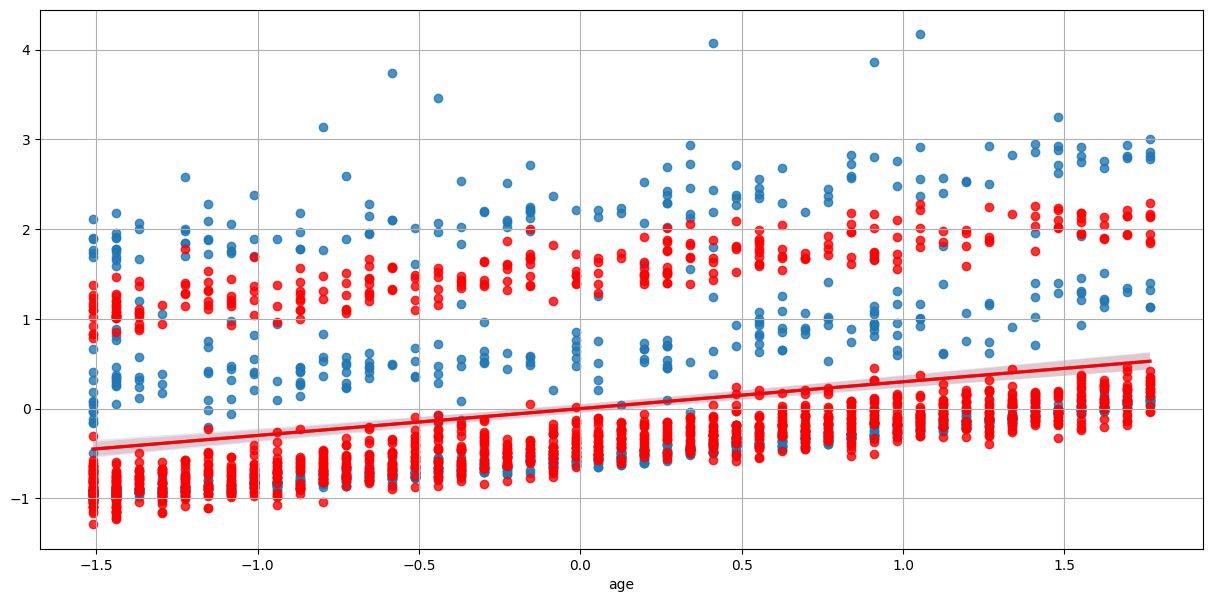

In [49]:
plt.figure(figsize=(15, 7))
sb.regplot(data=target_df, x='age', y='charges')
sb.regplot(data=target_df, x='age', y=ols_result.fit.fittedvalues, color='red')
plt.grid()
plt.plot()
plt.show()

#### 2) BMI에 따른 의료비 지출 비교

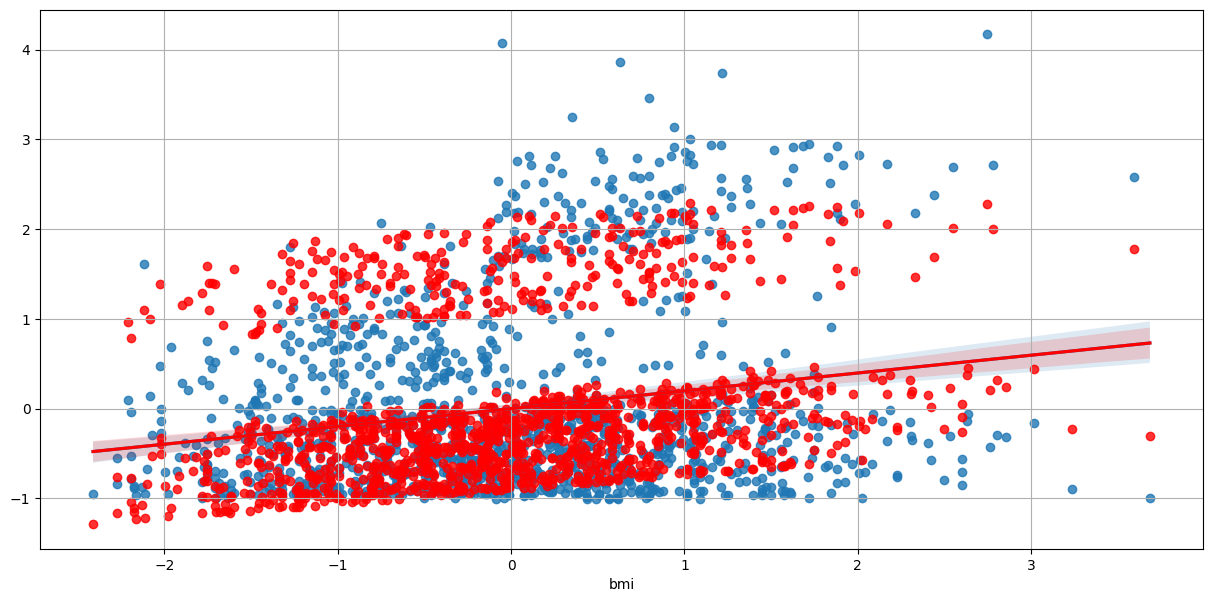

In [50]:
plt.figure(figsize=(15, 7))
sb.regplot(data=target_df, x='bmi', y='charges')
sb.regplot(data=target_df, x='bmi', y=ols_result.fit.fittedvalues, color='red')
plt.grid()
plt.plot()
plt.show()

## #06. 데이터 도메인 지식

도메인 지식이란 특정 분야의 전문화된 지식.

ex) 노하우

도메인 지식을 활용하면 도출된 분석모델의 성능을 개선할 수 있다.

### 1. 의료비 지출

의료비 지출에 대한 연령의 영향은 전 연령에 걸쳐 일정하지 않다.

20,30대와 50,60,70대 간의 의료비 지출 차이는 크게 날 수 밖에 없다.

기존의 연령변수는 전형적인 선형회귀 방정식을 따른다.

$y = {a_1}x + b$

하지만 고연령대일수록 증가푝이 커지는 현상을 설명하기 위해서는 높은 차수의 항을 회귀 모델에 추가해서 다항식으로 만들어 주면 된다.

$y = {a_2}^2x + {a_1}x + b$

#### 연령을 제곱한 형태로 연령 변수 교체

In [51]:
tmp_df = DataFrame({'age2': origin['age'] ** 2}, index=origin.index)
age2_std = StandardScaler().fit_transform(tmp_df)
target_df['age'] = age2_std
target_df.head()

,charges,age,bmi,children,smoker_yes
0,0.298584,-1.220462,-0.453320,-0.908614,1
1,-0.953689,-1.253341,0.509621,-0.078767,0
2,-0.728675,-0.844579,0.383307,1.580926,0
3,0.719843,-0.573551,-1.305531,-0.908614,0
4,-0.776802,-0.631311,-0.292556,-0.908614,0


#### 회귀분석 수행

In [52]:
xnames = list(target_df.columns)
xnames.remove('charges')

ols_result = helper.myOls(target_df, y = 'charges', x = xnames)

helper.prettyPrint(ols_result.table)
print(ols_result.result, end = "\n\n")

print(ols_result.goodness, end = "\n\n")

for i in ols_result.varstr:
    print(i)

+---------------------------+--------+------------+-----+---------+------------+---------+
|                           |      B |   표준오차 |   β | t       |   유의확률 |     VIF |
|---------------------------+--------+------------+-----+---------+------------+---------|
| ('charges', 'age')        | 0.3036 |      0.014 |   0 | 22.129* |          0 | 1.25123 |
| ('charges', 'bmi')        | 0.1603 |      0.014 |   0 | 11.689* |          0 | 1.08228 |
| ('charges', 'children')   | 0.0608 |      0.014 |   0 | 4.464*  |          0 | 1.01046 |
| ('charges', 'smoker_yes') | 1.9679 |      0.034 |   0 | 58.247* |          0 | 2.33147 |
+---------------------------+--------+------------+-----+---------+------------+---------+
𝑅(0.752), 𝑅^2(0.752), 𝐹(1013.), 유의확률(0.00), Durbin-Watson(2.094)

charges에 대하여 age,bmi,children,smoker_yes로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(4,1333) = 1013., p < 0.05).

age의 회귀계수는 0.3036(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
bmi의 회귀계수는 0.1603(p<0.05)로, charges에 대하여 

### 2. 비만도(BMI)

BMI는 특정 구간에서의 영향은 적지만 그 구간을 넘어가면 강한 영향을 미친다.

EDA를 진행하는 과정에서 BMI가 30이상인 사람과 30 미만인 사람들을 구분할 수 있음을 파악하였다.

이 내용을 더미변수로 추가할 수 있다.

#### BMI에 대한 비만도 파생 변수 만들기

In [53]:
tmp_df = origin.filter(['bmi'])
tmp_df['obesity'] = tmp_df['bmi'] >= 30
tmp_df['obesity'] = tmp_df['obesity'].astype(int)
tmp_df

,bmi,obesity
0,27.900,0
1,33.770,1
2,33.000,1
3,22.705,0
4,28.880,0
...,...,...
1333,30.970,1
1334,31.920,1
1335,36.850,1
1336,25.800,0


#### 파생변수를 원래의 데이터프레임에 결합

In [54]:
target_df['obesity'] = tmp_df['obesity']
target_df.head()

,charges,age,bmi,children,smoker_yes,obesity
0,0.298584,-1.220462,-0.453320,-0.908614,1,0
1,-0.953689,-1.253341,0.509621,-0.078767,0,1
2,-0.728675,-0.844579,0.383307,1.580926,0,1
3,0.719843,-0.573551,-1.305531,-0.908614,0,0
4,-0.776802,-0.631311,-0.292556,-0.908614,0,0


#### 회귀분석 수행

In [55]:
xnames = list(target_df.columns)
xnames.remove('charges')

ols_result = helper.myOls(target_df, y='charges', x=xnames)

helper.prettyPrint(ols_result.table)
print(ols_result.result, end="\n\n")

print(ols_result.goodness, end="\n\n")

for i in ols_result.varstr:
    print(i)

+---------------------------+--------+------------+-----+---------+------------+---------+
|                           |      B |   표준오차 |   β | t       |   유의확률 |     VIF |
|---------------------------+--------+------------+-----+---------+------------+---------|
| ('charges', 'age')        | 0.3032 |      0.014 |   0 | 22.302* |          0 | 1.31372 |
| ('charges', 'bmi')        | 0.0685 |      0.023 |   0 | 3.043*  |      0.002 | 1.92004 |
| ('charges', 'children')   | 0.0609 |      0.014 |   0 | 4.509*  |          0 | 1.01249 |
| ('charges', 'smoker_yes') | 1.9684 |      0.033 |   0 | 58.813* |          0 | 3.38861 |
| ('charges', 'obesity')    | 0.2304 |      0.045 |   0 | 5.119*  |          0 | 2.08254 |
+---------------------------+--------+------------+-----+---------+------------+---------+
𝑅(0.757), 𝑅^2(0.756), 𝐹(830.8), 유의확률(0.00), Durbin-Watson(2.098)

charges에 대하여 age,bmi,children,smoker_yes,obesity로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(5,1332) = 830.8, p < 0.05).

age의

### 3. 교효작용 추가

#### 비만도와 흡연여부

In [56]:
xnames = list(target_df.columns)
xnames.remove('charges')

ols_result = helper.myOls(target_df, expr="charges~age+bmi+children+smoker_yes+obesity+bmi*smoker_yes")

helper.prettyPrint(ols_result.table)
print(ols_result.result, end="\n\n")

print(ols_result.goodness, end="\n\n")

for i in ols_result.varstr:
    print(i)

+-------------------------------+---------+------------+-----+---------+------------+---------+
|                               |       B |   표준오차 |   β | t       |   유의확률 |     VIF |
|-------------------------------+---------+------------+-----+---------+------------+---------|
| ('charges', 'age')            |  0.3109 |      0.011 |   0 | 28.781* |          0 | 1.31372 |
| ('charges', 'bmi')            | -0.0981 |      0.019 |   0 | -5.203* |          0 | 1.92004 |
| ('charges', 'children')       |  0.0648 |      0.011 |   0 | 6.041*  |          0 | 1.01249 |
| ('charges', 'smoker_yes')     |  1.9651 |      0.027 |   0 | 73.902* |          0 | 3.38861 |
| ('charges', 'obesity')        |  0.2476 |      0.036 |   0 | 6.925*  |          0 | 2.08254 |
| ('charges', 'bmi:smoker_yes') |  0.7242 |      0.026 |   0 | 27.919* |          0 |       0 |
+-------------------------------+---------+------------+-----+---------+------------+---------+
𝑅(0.847), 𝑅^2(0.846), 𝐹(1227.), 유의확률(0.00), Durb

#### 최종 결과 비교

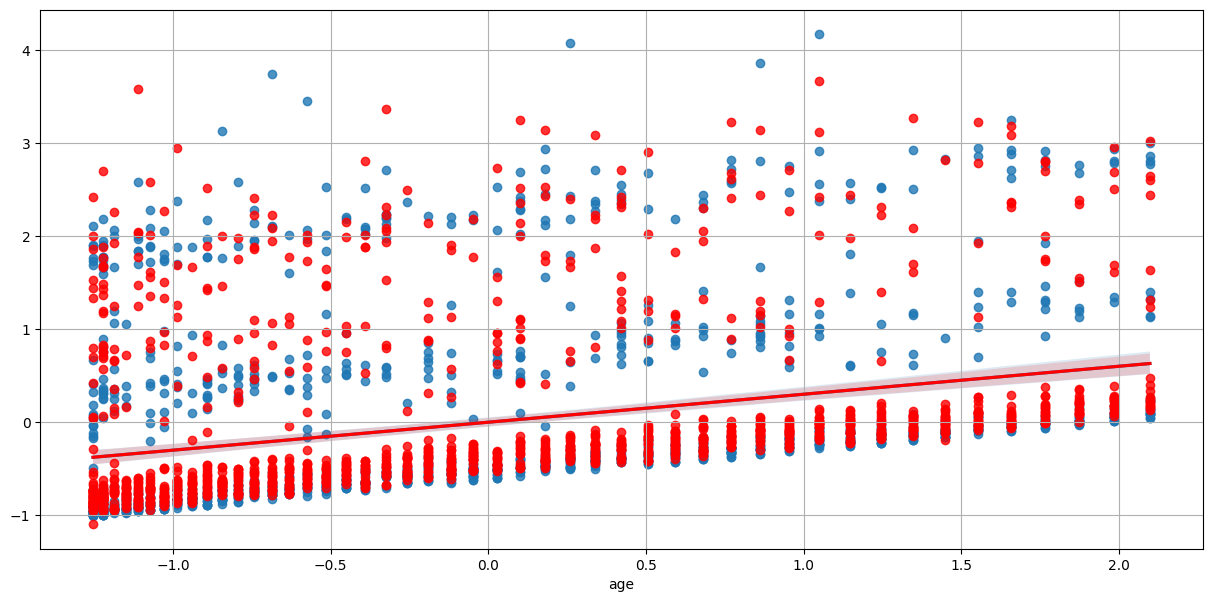

In [57]:
plt.figure(figsize=(15, 7))
sb.regplot(data=target_df, x='age', y='charges')
sb.regplot(data=target_df, x='age', y=ols_result.fit.fittedvalues, color='red')
plt.grid()
plt.plot()
plt.show()